In [1]:
import sys
sys.path.append("..")
%cd ..

c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021-1


In [278]:
from DataPrep.ImportData import importer
from Modelling import modelling
import keras
from keras import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, Input, Reshape
import pyforest
import torch
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from DataPrep.LagCreation import lags
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = importer().Import()

In [4]:
def smape(A, F):
    return 100/len(A) * np.sum( np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [5]:
df2 = pd.DataFrame()

<IPython.core.display.Javascript object>

In [6]:
df = df.set_index("Start Date")
df.index = df.index.to_period("D")

In [7]:
idx = pd.period_range(df.index.min(),df.index.max())
for i in range(8): 
    dat = df[df["Label"]==float(i)].reindex(idx, fill_value=0)
    dat.Label = float(i)
    df2 = df2.append(dat)

<IPython.core.display.Javascript object>

In [9]:
df2 = df2.sort_index()
df2["Start Date"] = df2.index

In [10]:
y = df2[["Energy (kWh)","Start Date", "Label"]]

In [69]:
y_cols = pd.DataFrame(columns=["Label 0","Label 1","Label 2","Label 3","Label 4","Label 5","Label 6","Label 7"])
for i in range(8):
    y_cols[f"Label {i}"]=y["Energy (kWh)"][y["Label"]==float(i)]
y_cols

<IPython.core.display.Javascript object>

,Label 0,Label 1,Label 2,Label 3,Label 4,Label 5,Label 6,Label 7
2011-08-03,1.679882,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-08-04,1.899242,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-08-05,1.574471,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-08-06,1.982032,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-08-07,2.232860,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2019-12-27,2.830458,2.939167,2.289273,4.334221,2.854240,3.614536,2.046395,4.018583
2019-12-28,2.942766,3.047410,2.309100,6.342500,3.379875,3.327432,2.465923,4.247111
2019-12-29,2.586043,2.481967,2.558100,5.014667,3.616300,1.770257,2.140442,2.646125
2019-12-30,3.519121,3.712893,2.701417,4.446316,3.624941,3.452742,2.370722,4.348600


0.0842574493649923


<IPython.core.display.Javascript object>

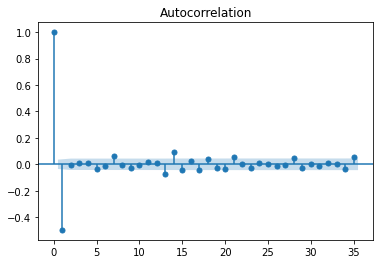

<IPython.core.display.Javascript object>

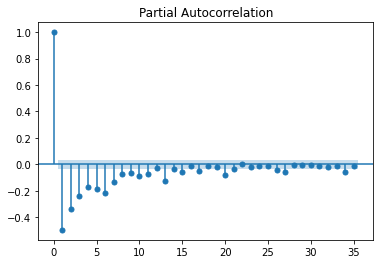

In [113]:
print(adfuller(yt["Label 0"].diff().dropna())[1])
plot_acf(yt["Label 0"].diff().dropna())
plt.show()
plot_pacf(yt["Label 0"].diff().dropna())
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

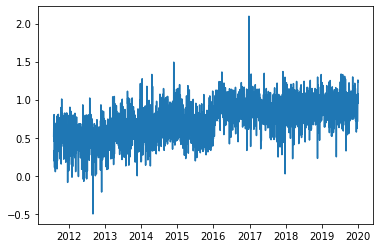

In [90]:
plt.plot(np.log(yt["Label 0"]))
plt.show()

In [214]:
train

30

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

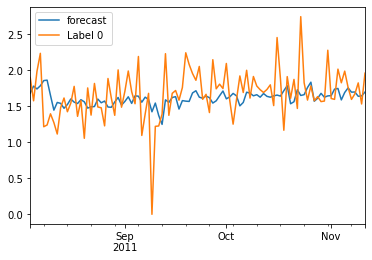

TypeError: float() argument must be a string or a number, not 'tuple'

In [282]:
pred = []
days_pred = []
train = int((len(y_cols["Label 0"].index))*0.1)
re = len(y_cols["Label 0"].index)-train
a = y_cols.index[0].to_timestamp()
b = y_cols.index[train].to_timestamp()

for i in range(1):#re):
    sam = SARIMAX(y_cols["Label 0"][a:b],order=(5,1,2), freq="D")
    sam_fit = sam.fit()

    days = 1
    n = b + pd.Timedelta(days=days)
    y_pred = sam_fit.forecast()
    #n1 = n + pd.Timedelta(days=1)
    #y_pred = sam_fit.forecast(steps = days)
    #y_pred = sam_fit.predict(start=n,end=n,typ="levels")
    #y_pred.index=y_pred.index.to_timestamp()
    
    pred.append(float(y_pred))

    a = a + pd.Timedelta(days=days)
    b = b + pd.Timedelta(days=days)
    days_pred.append(n)
    print(f"Progress {i}:{re}")


<IPython.core.display.Javascript object>

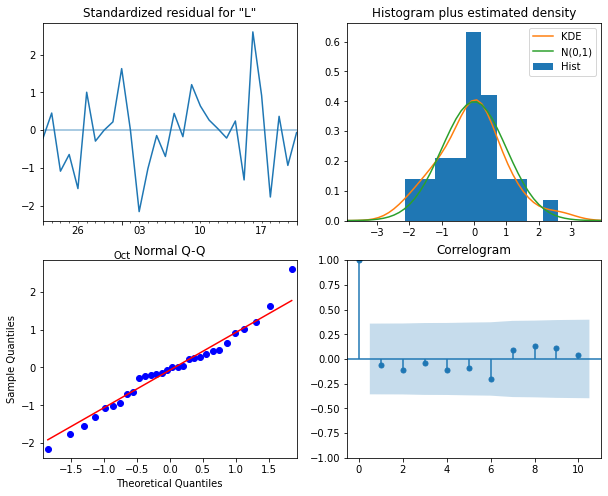

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Label 0   No. Observations:                   31
Model:               SARIMAX(5, 1, 2)   Log Likelihood                  -1.140
Date:                Wed, 21 Apr 2021   AIC                             22.280
Time:                        12:56:28   BIC                             36.292
Sample:                    09-21-2011   HQIC                            26.763
                         - 10-21-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0362      0.085     -0.427      0.670      -0.202       0.130
drift          0.0021      0.005      0.428      0.669      -0.008       0.012
ar.L1         -0.9651      1.431     -0.674      0.500      -3.771       1.841
ar.L2         -0.6105      0.625     -0.976      0.329      -1.836       0.615
ar.L3         -0.5654      0.687     -0.823      0.411      -1.913       0.782
ar.L4         -0.4673      0.518     -0.902      0.367      -1.483       0.548
ar.L5         -0.2987      0.355     -0.841      0.400      -0.995       0.398
ma.L1         -0.3425      1.595     -0.215      0.830      -3.469       2.784
ma.L2         -0.5725      1.247     -0.459      0.646      -3.016       1.871
sigma2         0.0543      0.041      1.322      0.186      -0.026       0.135
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.54
Prob(Q):                              0.74   Prob(JB):                         0.76
Heteroskedasticity (H):               1.69   Skew:                             0.25
Prob(H) (two-sided):                  0.42   Kurtosis:                         3.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [269]:
sam_fit.plot_diagnostics(figsize=(10,8))
plt.show()
sam_fit.summary()

In [270]:
pred = pd.DataFrame(pred)
pred.index = days_pred

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

r^2 score -0.8985594156943133


<IPython.core.display.Javascript object>

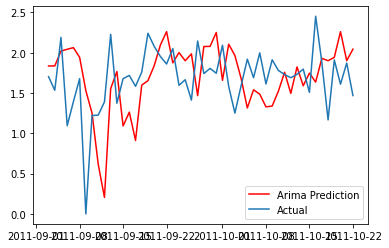

In [271]:
plt.plot(pred, color="red", label="Arima Prediction")
plt.plot(y_cols["Label 0"][days_pred[0]:days_pred[-1]],label="Actual")
plt.legend()
print(f'r^2 score {r2_score(y_cols["Label 0"][days_pred[0]:days_pred[-1]],pred)}')
plt.show()